# MNIST Digit Classifier using TensorFlow Keras
This notebook implements a convolutional neural network (CNN) to classify MNIST digits. It includes data preprocessing, training with advanced callbacks, and comprehensive evaluation metrics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 5) Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries loaded. TensorFlow version:", tf.__version__)

Libraries loaded. TensorFlow version: 2.20.0


## 1) Data Loading and Preprocessing

In [2]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Split train into train/val (50k/10k)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=10000, random_state=42, stratify=y_train_full
)

# Normalization [0, 1] and reshaping for CNN (batch, 28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot labels
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

print(f"Train shape: {x_train.shape}, Labels: {y_train_cat.shape}")
print(f"Val shape: {x_val.shape}, Labels: {y_val_cat.shape}")
print(f"Test shape: {x_test.shape}, Labels: {y_test_cat.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (50000, 28, 28, 1), Labels: (50000, 10)
Val shape: (10000, 28, 28, 1), Labels: (10000, 10)
Test shape: (10000, 28, 28, 1), Labels: (10000, 10)


## 2) Model Definition

In [3]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

C:\Users\019106594\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 3) Training with Callbacks

In [4]:
custom_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint('best_mnist_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
]

epochs = 20
batch_size = 128

history = model.fit(
    x_train, y_train_cat, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_val, y_val_cat),
    callbacks=custom_callbacks,
    verbose=1
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7953 - loss: 0.6489
Epoch 1: val_accuracy improved from None to 0.96970, saving model to best_mnist_model.keras

Epoch 1: finished saving model to best_mnist_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.9068 - loss: 0.3048 - val_accuracy: 0.9697 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9665 - loss: 0.1069
Epoch 2: val_accuracy improved from 0.96970 to 0.98130, saving model to best_mnist_model.keras

Epoch 2: finished saving model to best_mnist_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9707 - loss: 0.0958 - val_accuracy: 0.9813 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9774 - loss: 0.0738
Epoch 3: val_accuracy improved from 0.98130 to 0.98380, saving model to best_mnist_model.keras

Epoch 3: finished saving model to best_mnist_model.ker

## 4) Metrics and Evaluation

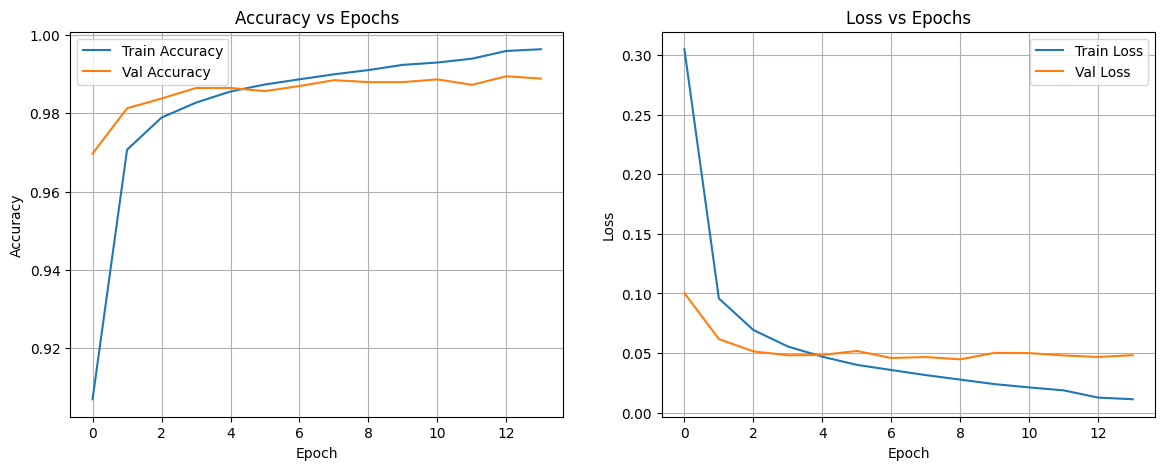


Final Test Loss: 0.0288
Final Test Accuracy: 0.9908


In [5]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Accuracy vs Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss vs Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Final test metrics
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

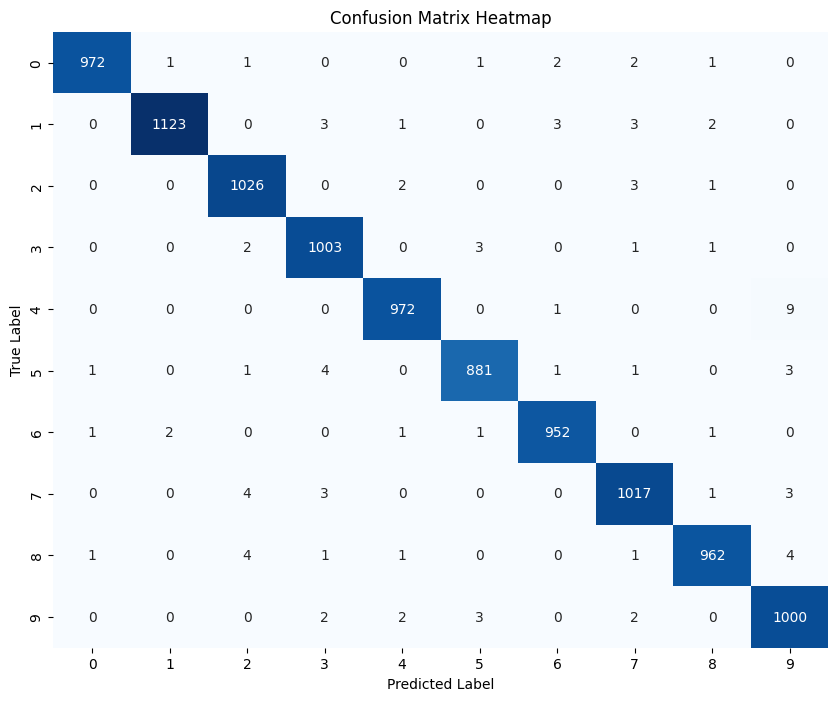

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [6]:
# Predictions
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [7]:
# Per-class accuracy table
class_acc = cm.diagonal() / cm.sum(axis=1)
df_acc = pd.DataFrame({'Digit': range(10), 'Accuracy': class_acc})
print("Per-Class Accuracy Table:")
print(df_acc.to_string(index=False))

Per-Class Accuracy Table:
 Digit  Accuracy
     0  0.991837
     1  0.989427
     2  0.994186
     3  0.993069
     4  0.989817
     5  0.987668
     6  0.993737
     7  0.989300
     8  0.987680
     9  0.991080


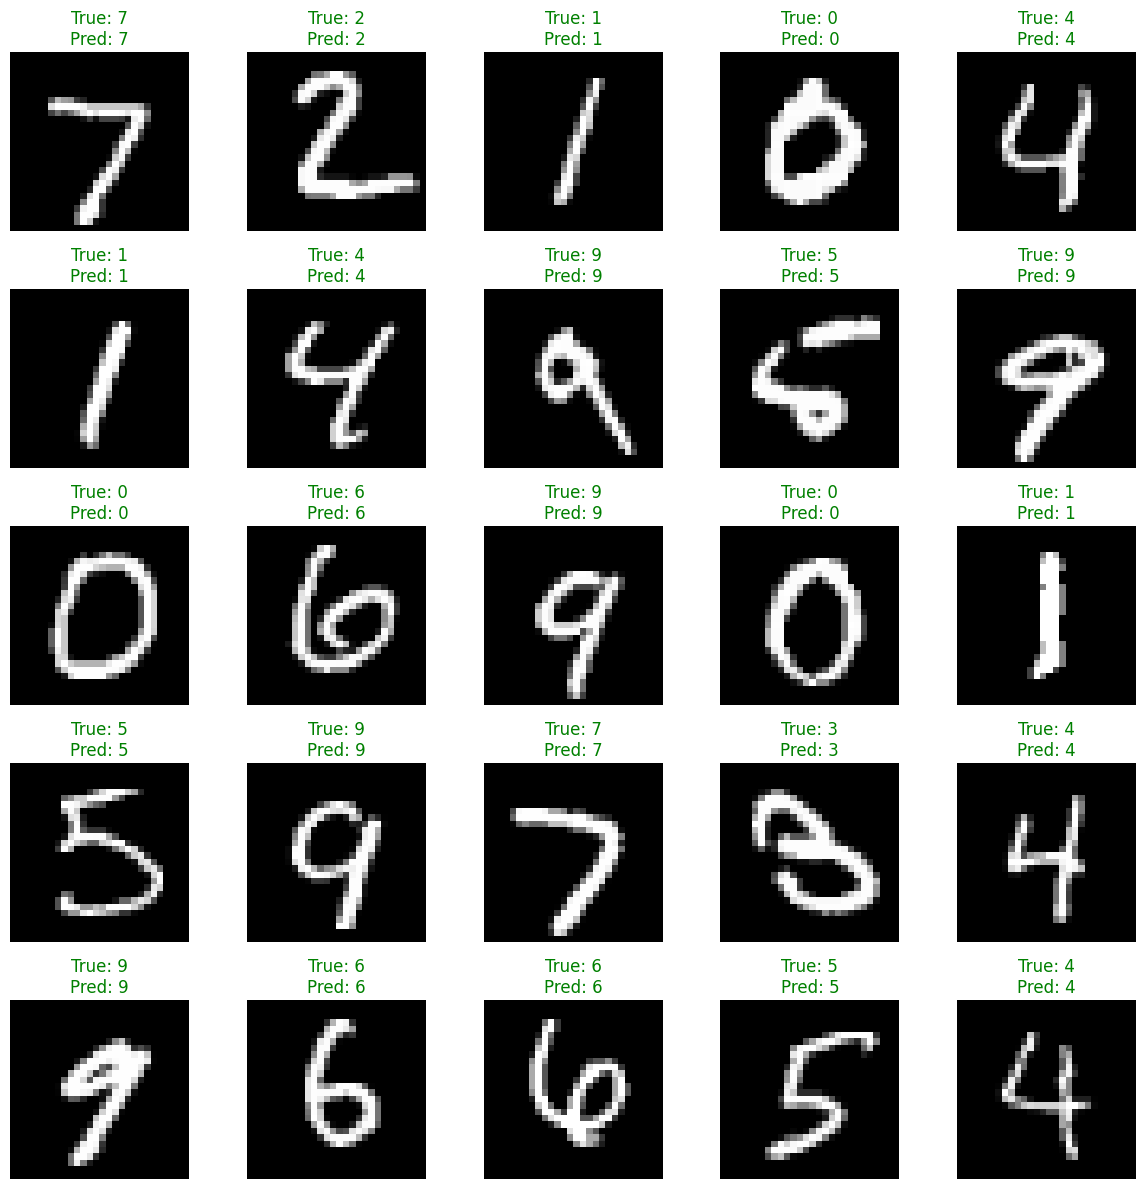

In [8]:
# Show 25 sample predictions
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    color = 'green' if y_pred[i] == y_test[i] else 'red'
    plt.title(f"True: {y_test[i]}\nPred: {y_pred[i]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()